In [92]:
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go
import plotly.express as px
from pandas_datareader import data as pdr

In [93]:
# set ticker
ticker = "SPY"

# set timeframe for data
start = '2020-01-01'
end = '2021-03-08'

# pull historical stock data from 1/10/2005 to 3/8/2021
yf.pdr_override()
df_spy_historical_stock_data = pdr.get_data_yahoo(ticker, start=start, end=end)

# drop Dividends and Stock Split columns
df_spy_historical_stock_data = df_spy_historical_stock_data.drop(columns=['Adj Close']).reset_index()
df_spy_historical_stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Volume
0,2020-01-02,323.540009,324.890015,322.529999,324.869995,59151200
1,2020-01-03,321.160004,323.640015,321.100006,322.410004,77709700
2,2020-01-06,320.489990,323.730011,320.359985,323.640015,55653900
3,2020-01-07,323.019989,323.540009,322.239990,322.730011,40496400
4,2020-01-08,322.940002,325.779999,322.670013,324.450012,68296000


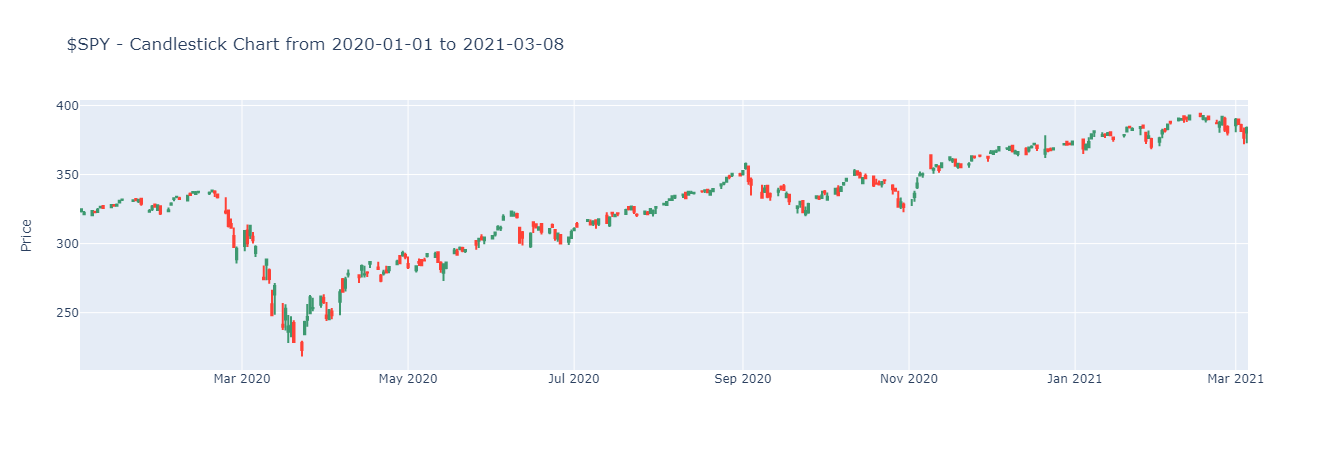

In [94]:

# plot SPY candlestick chart
spy_candlestick_chart = go.Figure(data=[go.Candlestick(x=df_spy_historical_stock_data['Date'],
                open=df_spy_historical_stock_data['Open'],
                high=df_spy_historical_stock_data['High'],
                low=df_spy_historical_stock_data['Low'],
                close=df_spy_historical_stock_data['Close'])])
spy_candlestick_chart.update_layout(
    title=f'$SPY - Candlestick Chart from {start} to {end}',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False)
spy_candlestick_chart.show()

In [95]:
# slice historical stock data for closing prices
spy_close_prices = df_spy_historical_stock_data[['Date','Close']]

#rename close column to spy_close and set Date as index
spy_close_prices.rename(columns = {'Close':'spy_close'}, inplace = True)
spy_close_prices.set_index(keys = "Date" , inplace = True)
spy_close_prices = spy_close_prices.drop_duplicates()
spy_close_prices.head()

C:\Users\531hy\anaconda3\envs\pyvizenv\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,spy_close
Date,
2020-01-02,324.869995
2020-01-03,322.410004
2020-01-06,323.640015
2020-01-07,322.730011
2020-01-08,324.450012


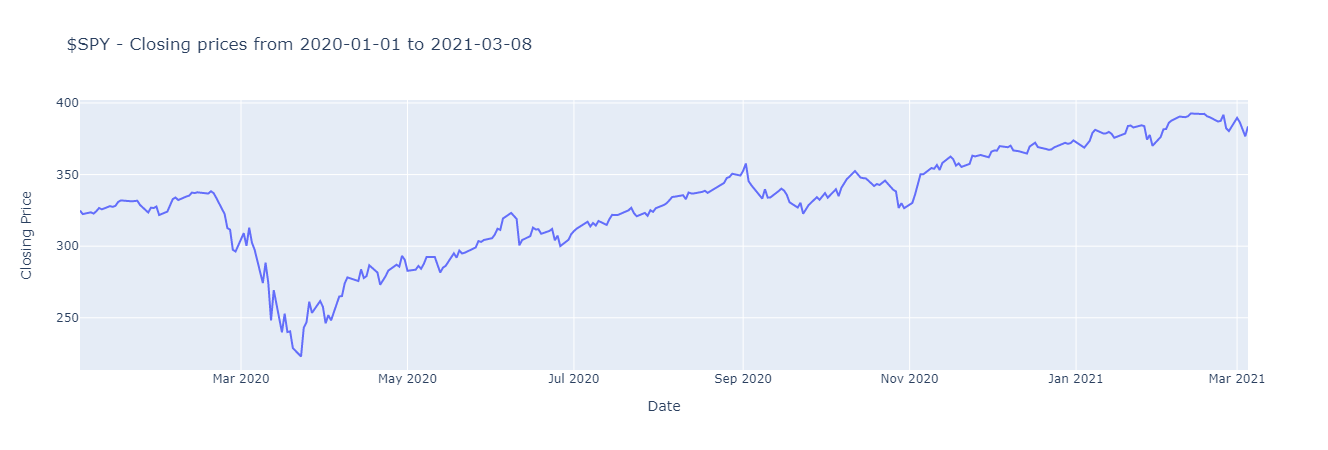

In [96]:

chart_spy_close_prices = px.line(spy_close_prices, y="spy_close", title=f'$SPY - Closing prices from {start} to {end}')
chart_spy_close_prices.update_layout(yaxis_title='Closing Price')
chart_spy_close_prices.show()


In [97]:

# import historical options data
df_spy_historical_options_data = pd.read_csv('SPY_2020.csv')

# drop unnecessary columns
df_spy_historical_options_data.drop(columns=['optionroot','optionext','impliedvol','delta','gamma','theta','vega',
                'optionalias','IVBid','IVAsk','bid','ask'],inplace=True)

In [99]:
#calc and insert column 'days to expiry'
df_spy_historical_options_data[['expiration','quotedate']] = df_spy_historical_options_data[['expiration','quotedate']].apply(pd.to_datetime) #if conversion required
df_spy_historical_options_data['days_to_expiry'] = (df_spy_historical_options_data['expiration'] - df_spy_historical_options_data['quotedate']).dt.days

In [100]:

df_spy_historical_options_data['last_trading_day'] = df_spy_historical_options_data['expiration'] - pd.Timedelta(1, unit='D')

In [102]:
#clean dataframe so we only observe options with 30 days remaining to expiry
# index_names = x[ x['days_to_expiry'] != 30 ].index 
index_names = df_spy_historical_options_data[df_spy_historical_options_data['last'] == 0].index
df_spy_historical_options_data.drop(index_names, inplace = True) 

#clean dataframe so we only observe at-the-money options
index_names2 = df_spy_historical_options_data[ df_spy_historical_options_data['strike'] != (df_spy_historical_options_data['underlying_last'])].index
df_spy_historical_options_data.drop(index_names2, inplace = True) 

#sort and reset
df_spy_historical_options_data.sort_values(by = ['type','expiration']).reset_index().head()


,index,underlying,underlying_last,exchange,type,expiration,quotedate,strike,last,volume,openinterest,days_to_expiry,last_trading_day
0,485380,SPY,242.0,*,call,2020-03-25,2020-03-24,242.0,5.70,27576,1780,1,2020-03-24
1,485732,SPY,242.0,*,call,2020-03-27,2020-03-24,242.0,8.48,8482,3573,3,2020-03-26
2,519182,SPY,254.0,*,call,2020-03-27,2020-03-27,254.0,0.33,30081,6086,0,2020-03-26
3,486146,SPY,242.0,*,call,2020-03-30,2020-03-24,242.0,10.03,1661,610,6,2020-03-29
4,519592,SPY,254.0,*,call,2020-03-30,2020-03-27,254.0,4.49,15292,17898,3,2020-03-29


In [104]:
#rename columns and reorder for merge
df_spy_historical_options_data.rename(columns={'last_trading_day':'Date'},inplace=True)
df_spy_historical_options_data= df_spy_historical_options_data[['Date', 'underlying', 'underlying_last', 'type', 'quotedate', 'strike', 'last', 'volume', 'openinterest','days_to_expiry']]
df_spy_historical_options_data.head()

,Date,underlying,underlying_last,type,quotedate,strike,last,volume,openinterest,days_to_expiry
485380,2020-03-24,SPY,242.0,call,2020-03-24,242.0,5.70,27576,1780,1
485381,2020-03-24,SPY,242.0,put,2020-03-24,242.0,4.95,5720,1165,1
485732,2020-03-26,SPY,242.0,call,2020-03-24,242.0,8.48,8482,3573,3
485733,2020-03-26,SPY,242.0,put,2020-03-24,242.0,7.65,7344,4241,3
486146,2020-03-29,SPY,242.0,call,2020-03-24,242.0,10.03,1661,610,6


In [106]:
#calculate in closing price to existing DF 
calls = pd.merge(df_spy_historical_options_data, spy_close_prices, how='left', on='Date')
calls['Options_Implied_Price'] = calls['strike'] + calls['last']
calls['last'].dropna()
put_index_names = calls[calls['type'] == 'put'].index
calls.drop(put_index_names, inplace = True) 


puts =  pd.merge(df_spy_historical_options_data, spy_close_prices, how='left', on='Date')
puts['Options_Implied_Price'] = (puts['strike'] - puts['last'])
puts['last'].dropna()
call_index_names = puts[puts['type'] == 'call'].index
puts.drop(call_index_names, inplace = True) 

df_stock_and_options = pd.concat([calls,puts],axis=0, sort=True).dropna()
df_stock_and_options.head()

,Date,Options_Implied_Price,days_to_expiry,last,openinterest,quotedate,spy_close,strike,type,underlying,underlying_last,volume
0,2020-03-24,247.70,1,5.70,1780,2020-03-24,243.149994,242.0,call,SPY,242.0,27576
2,2020-03-26,250.48,3,8.48,3573,2020-03-24,261.200012,242.0,call,SPY,242.0,8482
6,2020-03-30,252.64,7,10.64,559,2020-03-24,261.649994,242.0,call,SPY,242.0,2501
8,2020-03-31,253.04,8,11.04,1035,2020-03-24,257.750000,242.0,call,SPY,242.0,1507
10,2020-04-02,253.99,10,11.99,5067,2020-03-24,251.830002,242.0,call,SPY,242.0,2919


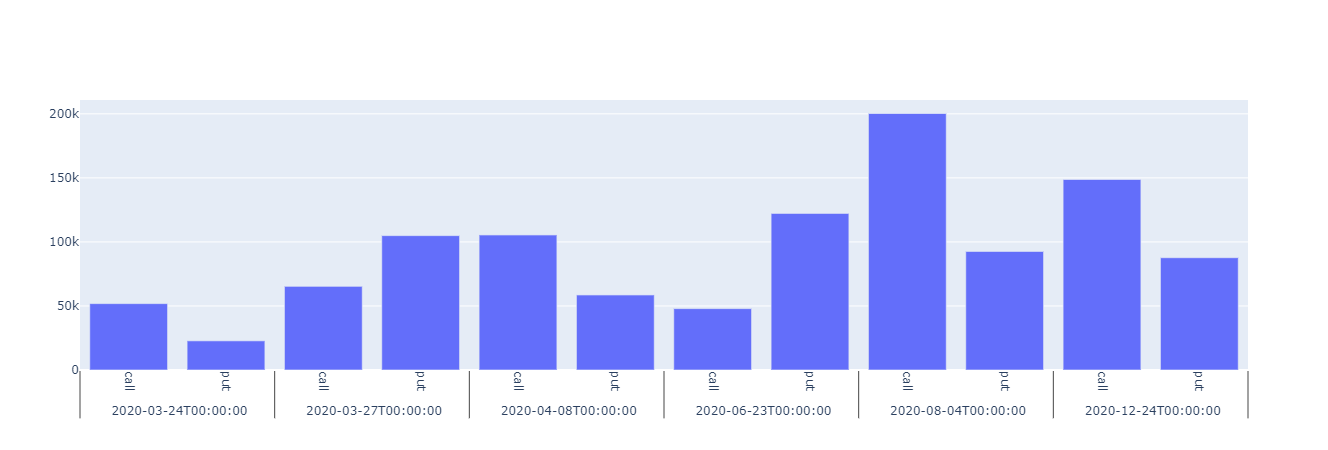

In [107]:
# calculate open interest by day and groupby date and option type
open_interest_by_day = df_spy_historical_options_data.groupby(['quotedate','type'])[['openinterest']].sum().reset_index()

# calculate options volume by day and groupby date and option type
option_volume_by_day = df_spy_historical_options_data.groupby(['quotedate','type'])[['volume']].sum().reset_index()
option_volume_by_day.head(10)

chart_option_volume_by_day = go.Figure(data=[
    go.Bar(name='Calls', x=[option_volume_by_day['quotedate'], option_volume_by_day['type']], y=option_volume_by_day['volume'])])
#     go.Bar(name='Puts', x=[option_volume_by_day['quotedate'], option_volume_by_day['type']], y=option_volume_by_day['volume'])


# Change the bar mode
chart_option_volume_by_day.update_layout(barmode='group')
chart_option_volume_by_day.update_xaxes(tickangle=90)
# chart_open_interest_by_day.show()

# calls_open_interest_by_day = df_spy_historical_options_data.groupby('quotedate')['openinterest'].sum()

In [86]:
# calculate options volume by day and groupby date and option type
option_volume_by_day = df_spy_historical_options_data.groupby(['quotedate','type'])[['volume']].sum().reset_index()
option_volume_by_day.set_index(pd.to_datetime(option_volume_by_day['quotedate'], infer_datetime_format=True), inplace=True)
option_volume_by_day.drop(columns=['quotedate'], inplace=True)
option_volume_by_day.head(20)

,type,volume
quotedate,,
2020-03-24,call,51842
2020-03-24,put,22786
2020-03-27,call,65353
2020-03-27,put,104916
2020-04-08,call,105438
2020-04-08,put,58597
2020-06-23,call,47917
2020-06-23,put,122260
2020-08-04,call,200254


In [15]:
# get call volumes df
call_volume = option_volume_by_day.loc[option_volume_by_day['type'] == 'call']
call_volume = call_volume.rename(columns={"volume": "call volume"})
call_volume = call_volume.drop(columns = 'type')
call_volume.head()

,call volume
quotedate,
2020-03-24,51842
2020-03-27,65353
2020-04-08,105438
2020-06-23,47917
2020-08-04,200254


In [16]:
# get put volumes df
put_volume = option_volume_by_day.loc[option_volume_by_day['type'] == 'put']
put_volume = put_volume.rename(columns={"volume": "put volume"})
put_volume = put_volume.drop(columns = 'type')
put_volume.head()

,put volume
quotedate,
2020-03-24,22786
2020-03-27,104916
2020-04-08,58597
2020-06-23,122260
2020-08-04,92577


In [17]:
# sum option daily volume 

option_volume_sum = option_volume_by_day.groupby('quotedate').sum()
option_volume_sum = option_volume_sum.rename(columns={"volume": "total option volume"})
option_volume_sum.head()

,total option volume
quotedate,
2020-03-24,74628
2020-03-27,170269
2020-04-08,164035
2020-06-23,170177
2020-08-04,292831


In [18]:
# options implied price by type
option_implied_price_by_type = df_stock_and_options.groupby(['quotedate','type'])[['Options_Implied_Price']].mean().reset_index()
option_implied_price_by_type.set_index(pd.to_datetime(option_implied_price_by_type['quotedate'], infer_datetime_format=True), inplace=True)
option_implied_price_by_type.head()

,quotedate,type,Options_Implied_Price
quotedate,,,
2020-03-24,2020-03-24,call,258.241818
2020-03-24,2020-03-24,put,225.115909
2020-03-27,2020-03-27,call,271.886667
2020-03-27,2020-03-27,put,235.600000
2020-04-08,2020-04-08,call,288.965238


In [63]:
# get put options implied price 
put_implied_price = option_implied_price_by_type.loc[option_implied_price_by_type['type'] == 'put']
put_implied_price = put_implied_price.rename(columns={"Options_Implied_Price": "put price"})
put_implied_price = put_implied_price.drop(columns = ['type', 'quotedate'])
put_implied_price


,put price
quotedate,
2020-03-24,225.115909
2020-03-27,235.600000
2020-04-08,258.187143
2020-06-23,299.828947
2020-08-04,320.637368
2020-12-24,363.884000


In [64]:
# get buy options implied price 
call_implied_price = option_implied_price_by_type.loc[option_implied_price_by_type['type'] == 'call']
call_implied_price = call_implied_price.rename(columns={"Options_Implied_Price": "call price"})
call_implied_price = call_implied_price.drop(columns = ['type', 'quotedate'])
call_implied_price

,call price
quotedate,
2020-03-24,258.241818
2020-03-27,271.886667
2020-04-08,288.965238
2020-06-23,324.109474
2020-08-04,338.711053
2020-12-24,374.095000


In [70]:
# call option volume daily change
call_implied_price_change = call_implied_price.pct_change()
call_implied_price_change = call_implied_price_change.rename(columns={"call price": "call change"})
call_implied_price_change

,call change
quotedate,
2020-03-24,NaN
2020-03-27,0.052837
2020-04-08,0.062815
2020-06-23,0.121621
2020-08-04,0.045051
2020-12-24,0.104466


In [108]:
call_implied_price.dtypes

call price    float64
dtype: object

In [71]:
# put option volume daily change
put_implied_price_change = put_implied_price.pct_change()
put_implied_price_change = put_implied_price_change.rename(columns={"put price": "put change"})
put_implied_price_change

,put change
quotedate,
2020-03-24,NaN
2020-03-27,0.046572
2020-04-08,0.095871
2020-06-23,0.161285
2020-08-04,0.069401
2020-12-24,0.134877


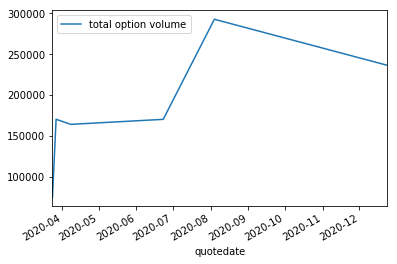

In [72]:
#plot option valume by day
option_volume_sum.plot()

In [73]:
# option volume daily change
option_volume_daily_change = option_volume_sum.pct_change()
option_volume_daily_change.columns = [ 'option volume daily change']
option_volume_daily_change.head()

,option volume daily change
quotedate,
2020-03-24,NaN
2020-03-27,1.281570
2020-04-08,-0.036613
2020-06-23,0.037443
2020-08-04,0.720744


In [74]:
#calculate spy daily returns
spy_daily_returns = spy_close_prices.pct_change()
spy_daily_returns.columns = [ 'daily_return']
spy_daily_returns.head()

,daily_return
Date,
2020-01-02,NaN
2020-01-03,-0.007572
2020-01-06,0.003815
2020-01-07,-0.002812
2020-01-08,0.005330


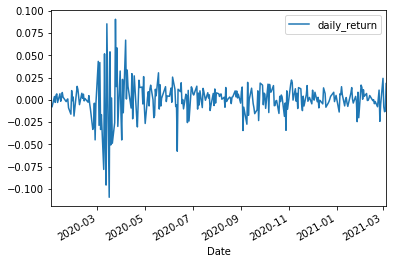

In [75]:
# plot spy daily returns
spy_daily_returns.plot()

In [76]:
# concat option volume and spy daily return

option_sum_and_daily_return = pd.concat([option_volume_sum, spy_daily_returns, call_volume, put_volume, call_implied_price, put_implied_price, call_implied_price_change, put_implied_price_change], axis="columns", join="inner")
option_sum_and_daily_return 


,total option volume,daily_return,call volume,put volume,call price,put price,call change,put change
2020-03-24,74628,0.090603,51842,22786,258.241818,225.115909,NaN,NaN
2020-03-27,170269,-0.029786,65353,104916,271.886667,235.600000,0.052837,0.046572
2020-04-08,164035,0.033568,105438,58597,288.965238,258.187143,0.062815,0.095871
2020-06-23,170177,0.004604,47917,122260,324.109474,299.828947,0.121621,0.161285
2020-08-04,292831,0.003863,200254,92577,338.711053,320.637368,0.045051,0.069401
2020-12-24,236418,0.003890,148744,87674,374.095000,363.884000,0.104466,0.134877


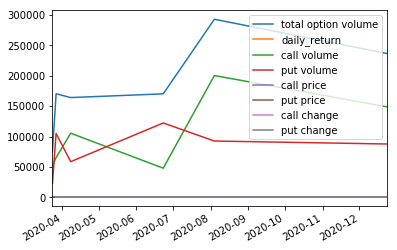

In [77]:
#plot option volume daily change and spy daily return
option_sum_and_daily_return.plot()

In [80]:
# import seaborn liabrary
import seaborn as sns

In [82]:
#calculate corralation
stock_option_corr = option_sum_and_daily_return.corr()
stock_option_corr

,total option volume,daily_return,call volume,put volume,call price,put price,call change,put change
total option volume,1.000000,-0.640328,0.877876,0.571436,0.791965,0.783825,-0.272694,-0.162010
daily_return,-0.640328,1.000000,-0.252965,-0.895703,-0.417556,-0.383733,0.140950,0.410967
call volume,0.877876,-0.252965,1.000000,0.108651,0.667963,0.677654,-0.411704,-0.243935
put volume,0.571436,-0.895703,0.108651,1.000000,0.499312,0.465809,0.432811,0.255385
call price,0.791965,-0.417556,0.667963,0.499312,1.000000,0.999089,0.489203,0.562378
put price,0.783825,-0.383733,0.677654,0.465809,0.999089,1.000000,0.473777,0.550648
call change,-0.272694,0.140950,-0.411704,0.432811,0.489203,0.473777,1.000000,0.952576
put change,-0.162010,0.410967,-0.243935,0.255385,0.562378,0.550648,0.952576,1.000000


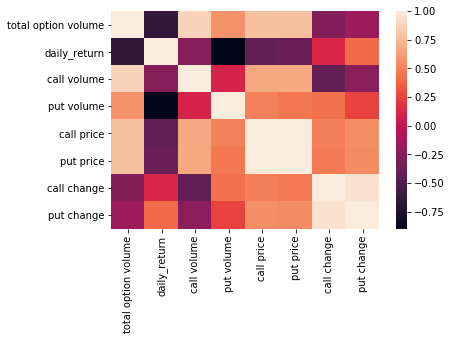

In [83]:
# spy and option corralation heatmap
sns.heatmap(stock_option_corr)